Увы... весь ноутбук выполняется 15 минут:(

# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [30]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [31]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-14 20:05:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [            <=>     ] 201.24M  21.2MB/s    in 11s     

2023-10-14 20:06:08 (18.2 MB/s) - ‘data.txt.zip’ saved [211011981]



In [32]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [33]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [35]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [36]:
set_random_seed(42)

In [37]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge().fit(X_train, y_train)
rmse_for_model = mean_squared_error(y_test, model.predict(X_test), squared = False)

rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [39]:
best_rmse_metric = mean_squared_error(y_test, [y_train.mean()] * len(X_test), squared = False)
best_rmse_metric

10.85246390513634

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [40]:
X_train_slice = torch.tensor(X_train, dtype=torch.float32)[:10000, :] # для ускорения берем срезы
y_train_slice = torch.tensor(y_train, dtype=torch.float32)[:10000]
X_test_slice = torch.tensor(X_test, dtype=torch.float32)[:5000, :]
y_test_slice = torch.tensor(y_test, dtype=torch.float32)[:5000]

In [41]:
def Huber(y_true, y_pred):
    eps = 0.1
    mse_h = (y_true - y_pred) ** 2 / 2
    mae_h = (torch.abs(y_true - y_pred) - eps / 2) * eps
    loss = torch.where(torch.abs(y_true - y_pred) < eps, mse_h, mae_h)
    return torch.mean(loss)

Логично выводить значение лосса и целевой метрики на обучающей и на тестовой выборке, а далее последуют соответствующие графики.

In [42]:
set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 1)) # К-во входов = к-ву признаков; Выход 1, т.к. предсказываем 1 целевую переменную

train_losses = []
val_losses = []
huber_train_losses = []
huber_val_losses = [] # В качестве "целевой метрики на тестовой выборке" буду использовать функцию потерь Хубера

for epoch in range(10):
    y_pred = model(X_train_slice)
    train_loss = torch.sqrt(torch.mean((y_pred - y_train_slice) ** 2)) # как и в 0 задании, будем использовать rmse
    train_loss.backward() # считаем градиенты обратным проходом
    train_losses.append(train_loss.detach().numpy())

    # обновление весов и смещений: используем parameters, аналогично как в 1-м семинаре
    for par in model.parameters():
        par.data -= 0.05 * par.grad # делаем шаг градиентного спуска с lr = 0.05
        par.grad.data.zero_() # обнуляем посчитанные градиенты параметров

    with torch.no_grad(): # выключаем подсчет градиентов
        huber_train_loss = Huber(y_train_slice, y_pred)
        huber_train_losses.append(huber_train_loss)

        y_pred = model(X_test_slice)
        val_loss = torch.sqrt(torch.mean((y_pred - y_test_slice) ** 2))
        val_losses.append(val_loss)

        huber_val_loss = Huber(y_test_slice, y_pred)
        huber_val_losses.append(huber_val_loss)

    print(f'Epoch: {epoch} | Train RMSE: {train_loss} | Val RMSE: {val_loss} | Train Huber (target metric): {huber_train_loss} | Val Huber (target metric): {huber_val_loss}')

Epoch: 0 | Train RMSE: 1998.94482421875 | Val RMSE: 1998.2528076171875 | Train Huber (target metric): 199.88690185546875 | Val Huber (target metric): 199.8174591064453
Epoch: 1 | Train RMSE: 1998.8931884765625 | Val RMSE: 1998.201416015625 | Train Huber (target metric): 199.88172912597656 | Val Huber (target metric): 199.81231689453125
Epoch: 2 | Train RMSE: 1998.84130859375 | Val RMSE: 1998.1500244140625 | Train Huber (target metric): 199.8765411376953 | Val Huber (target metric): 199.8072052001953
Epoch: 3 | Train RMSE: 1998.7894287109375 | Val RMSE: 1998.0986328125 | Train Huber (target metric): 199.871337890625 | Val Huber (target metric): 199.8020477294922
Epoch: 4 | Train RMSE: 1998.7376708984375 | Val RMSE: 1998.047119140625 | Train Huber (target metric): 199.8661651611328 | Val Huber (target metric): 199.79690551757812
Epoch: 5 | Train RMSE: 1998.685791015625 | Val RMSE: 1997.995849609375 | Train Huber (target metric): 199.8610076904297 | Val Huber (target metric): 199.79173278

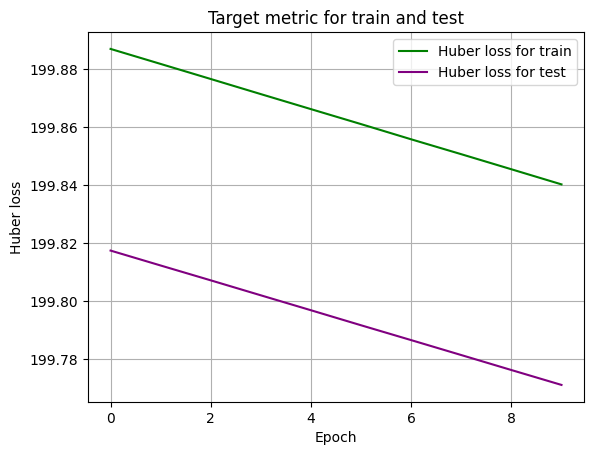

In [43]:
plt.plot(np.arange(10), huber_train_losses, 'g')
plt.plot(np.arange(10), huber_val_losses, 'purple')
plt.grid(True)
plt.legend(['Huber loss for train', 'Huber loss for test'])
plt.xlabel('Epoch')
plt.ylabel('Huber loss')
plt.title('Target metric for train and test')
plt.show()

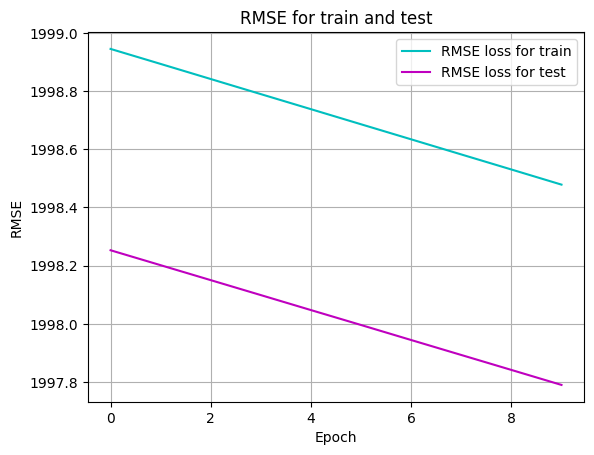

In [44]:
plt.plot(np.arange(10), train_losses, 'c')
plt.plot(np.arange(10), val_losses, 'm')
plt.grid(True)
plt.legend(['RMSE loss for train', 'RMSE loss for test'])
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE for train and test')
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [45]:
class YearDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx]

[Данная ссылочка](https://discuss.pytorch.org/t/rmse-loss-function/16540/2) до конца убедили меня в необходимости создания класса для RMSE:

In [46]:
class RMSELoss(nn.Module):
  def __init__(self):
    super().__init__() # инициализация родителя
    self.mse = nn.MSELoss()

  def forward(self, y_pred, y_true):
    return torch.sqrt(self.mse(y_pred, y_true))

Далее, чтобы не быть голословным в третьем задании, будет показан путь к итоговому результату. Если интересует лучшая модель, то можно сразу посмотреть на последний эксперимент (№6).

### Эксперимент №1

Для начала помня, что в прошлом номере была "космическая ошибка" попробуем улучшить модель из прошлого номера изменением архитектуры. Сделаем двуслойную полносвязную сеть: добавим функцию активации ReLU и ещё один линейный слой.

In [47]:
set_random_seed(42)

train_set = YearDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)

test_set = YearDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)

model = nn.Sequential(nn.Linear(X_train.shape[1], 30),  nn.ReLU(), nn.Linear(30, 1))
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) # для обновления весов модели
criterion = RMSELoss()

model.to(device)

Sequential(
  (0): Linear(in_features=90, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

Добавим параметр число эпох в предлагаемую функцию train(), а также будем возвращать массив эпох и соответствующую эпохе ошибку на тесте; функция test() же не понадобится (т.к. мне не нужно возвращать предикты на тесте, а нужны ошибки)

In [48]:
def train(model, optimizer, criterion, train_loader, test_loader, n_epochs=5):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    ----------
    returns:
        epochs - list of epochs
        all_losses - list of losses on test
    """
    all_val_losses = []
    for epoch in range(n_epochs):
        for x_train, y_train in tqdm(train_loader):
            y_pred = torch.flatten(model(x_train.to(device)))
            loss = criterion(y_pred, y_train.to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        val_loss = []
        with torch.no_grad():  # выключить подсчет градиентов
            for x_val, y_val in tqdm(test_loader):
                y_pred = torch.flatten(model(x_val.to(device)))
                loss = nn.MSELoss()(y_pred, y_val.to(device))
                val_loss.append(loss.cpu().numpy())
        all_val_losses.append(np.sqrt(np.mean(val_loss)))
    return list(range(n_epochs)), all_val_losses

In [49]:
epochs, all_losses = train(model, optimizer, criterion, train_loader, test_loader, 3)
for epoch in epochs:
    print(f"Epoch: {epoch}, loss: {all_losses[epoch]}")

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 0, loss: 351.5093994140625
Epoch: 1, loss: 164.58180236816406
Epoch: 2, loss: 204.2877197265625


В прошлом номере ошибка была гораздо больше, однако мы все еще далеки до идеала.

### Эксперимент №2

Теперь, попробуем использовать предложенную в задании нормировку таргета. Приэтом необходимо помнить, что при применении нормализатора к выборке shape меняется (будет работа с массивом одномерных массивов). В связи с этим при необходимости будем превращать такой массив массивов в одномерный массив (для этого использую flatten).

In [50]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler()
y_train_normed = normalizer.fit_transform(y_train.reshape(-1, 1))
y_test_normed = normalizer.transform(y_test.reshape(-1, 1))

In [51]:
set_random_seed(42)

train_set = YearDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_normed, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)

test_set = YearDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_normed, dtype=torch.float32))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)

model = nn.Sequential(nn.Linear(X_train.shape[1], 30),  nn.ReLU(), nn.Linear(30, 1))
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = RMSELoss()

model.to(device)

Sequential(
  (0): Linear(in_features=90, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [52]:
def train(model, optimizer, criterion, train_loader, test_loader, n_epochs=5):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    ----------
    returns:
        epochs - list of epochs
        all_losses - list of losses on test
    """
    all_losses = []
    for epoch in range(n_epochs):
        # тренировка
        for x_train, y_train in tqdm(train_loader):
            y_pred = model(x_train.to(device))
            loss = criterion(torch.flatten(y_pred), torch.flatten(y_train).to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        val_loss = []
        with torch.no_grad():  # выключить подсчет градиентов
            for x_val, y_val in tqdm(test_loader):
                y_pred = model(x_val.to(device)).cpu()
                loss = nn.MSELoss()(torch.tensor(normalizer.inverse_transform(y_pred).flatten(), dtype=torch.float32).to(device),
                                 torch.tensor(normalizer.inverse_transform(y_val).flatten(), dtype=torch.float32).to(device))
                val_loss.append(loss.cpu().numpy())
        all_losses.append(np.sqrt(np.mean(val_loss)))
        # print(f"Epoch: {epoch}, loss: {np.sqrt(np.mean(val_loss))}") # для отслеживания процесса обучения
    return list(range(n_epochs)), all_losses

In [53]:
epochs, all_losses = train(model, optimizer, criterion, train_loader, test_loader, 5)
for epoch in epochs:
    print(f"Epoch: {epoch}, loss: {all_losses[epoch]}")

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 0, loss: 9.515518188476562
Epoch: 1, loss: 9.501251220703125
Epoch: 2, loss: 9.442277908325195
Epoch: 3, loss: 9.45424747467041
Epoch: 4, loss: 9.451353073120117


Заметим, что ошибка стала гораздо меньше. Ура!

### Эксперимент №3

Теперь попробуем разные оптимизаторы.

Изменим оптимизатор SGD на другие... я сначала очень испугался в разы возросшей ошибке. Но потом решил попробовать поменять гиперпараметры: увеличение длины шага никак меня не порадовало, а вот уменьшение удивило: каждый раз брал все меньше и меньше длину шага, и остановился на lr = 0.001 (что кстати является значением по умолчанию для Adam'а и RMSprop'а).

Рассматривая срез выборки, стало ясно что Adam работает чуть лучше RMSprop'а и SGD с momentum'ом. Поставим Adam.

Также после этого я добавил шедулер и качество стало получше.

Изменим немного функцию train() для дальнейшего удобства: будем возвращать еще и ошибки на обучающей выборке для построения графиков.

In [54]:
def train(model, optimizer, criterion, train_loader, test_loader, scheduler, n_epochs=5):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    ----------
    returns:
        epochs - list of epochs
        all_train_losses - list of losses on train
        all_val_losses - list of losses on test
    """
    all_train_losses = []
    all_val_losses = []
    for epoch in range(n_epochs):
        train_loss = []
        for x_train, y_train in tqdm(train_loader):
            y_pred = model(x_train.to(device))
            loss = criterion(torch.flatten(y_pred), torch.flatten(y_train).to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                train_mse = nn.MSELoss()(torch.tensor(normalizer.inverse_transform(y_pred.cpu()).flatten(), dtype=torch.float32).to(device),
                                    torch.tensor(normalizer.inverse_transform(y_train).flatten(), dtype=torch.float32).to(device))
                train_loss.append(train_mse.cpu().numpy())

        all_train_losses.append(np.sqrt(np.mean(train_loss)))

        val_loss = []
        with torch.no_grad():  # выключить подсчет градиентов
            for x_val, y_val in tqdm(test_loader):
                y_pred = model(x_val.to(device))
                val_mse = nn.MSELoss()(torch.tensor(normalizer.inverse_transform(y_pred.cpu()).flatten(), dtype=torch.float32).to(device),
                                 torch.tensor(normalizer.inverse_transform(y_val).flatten(), dtype=torch.float32).to(device))
                val_loss.append(val_mse.cpu().numpy())

        all_val_losses.append(np.sqrt(np.mean(val_loss)))
        # print(f"Epoch: {epoch}, loss: {np.sqrt(np.mean(val_loss))}") # для отслеживания процесса обучения

        scheduler.step()
    return list(range(n_epochs)), all_train_losses, all_val_losses

In [55]:
set_random_seed(42)

train_set = YearDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_normed, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)

test_set = YearDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_normed, dtype=torch.float32))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)

model = nn.Sequential(nn.Linear(X_train.shape[1], 30), nn.ReLU(), nn.Linear(30, 1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

lambda_func = lambda epoch: 0.975**epoch # сдержим adam от проскакивания минимума, сделаем шаги поменьше у минимума
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

criterion = RMSELoss()

model.to(device)

epochs, all_train_losses, all_test_losses = train(model, optimizer, criterion, train_loader, test_loader, scheduler, 5)
for epoch in epochs:
    print(f"Epoch: {epoch}, test loss: {all_test_losses[epoch]}")

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 0, test loss: 9.368663787841797
Epoch: 1, test loss: 9.238971710205078
Epoch: 2, test loss: 9.194478034973145
Epoch: 3, test loss: 9.160606384277344
Epoch: 4, test loss: 9.15406322479248


### Эксперимент №4

Также я понял, что при изменении архитектуры необходимо заново аккуратно подбирать гиперпараметры. Далее про изменение архитектуры... я пытался поменять ReLU на другую функцию активации, но лучше не становилось. Далее я попробовал подобавлять линейные слои, и лучшим решением для моей модели стало сделать 3 линейных слоя (дальнейшее добавление слоев не дало никаких плодов). Поэксперементировав с количеством выходов и входов в линейные слои, я подобрал те, с которыми моя модель показала себя лучше всего.

In [56]:
set_random_seed(42)

lay1, lay2, lay3 = 80, 50, 20

train_set = YearDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_normed, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)

test_set = YearDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_normed, dtype=torch.float32))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)

model = nn.Sequential(nn.Linear(X_train.shape[1], lay1), nn.ReLU(), nn.Linear(lay1, lay2), nn.ReLU(), nn.Linear(lay2, lay3), nn.ReLU(), nn.Linear(lay3, 1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

lambda_func = lambda epoch: 0.975**epoch # сдержим adam от проскакивания минимума, сделаем шаги поменьше у минимума
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

criterion = RMSELoss()

model.to(device)

epochs, all_train_losses, all_test_losses = train(model, optimizer, criterion, train_loader, test_loader, scheduler, 5)
for epoch in epochs:
    print(f"Epoch: {epoch}, test loss: {all_test_losses[epoch]}")

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch: 0, test loss: 9.32331371307373
Epoch: 1, test loss: 9.113981246948242
Epoch: 2, test loss: 9.03701400756836
Epoch: 3, test loss: 8.989331245422363
Epoch: 4, test loss: 8.953168869018555


### Эксперимент №5 и №6

В данном эксперименте будем пробовать менять значения гиперпараметров. В лекциях говорилось о том, что нужно аккуратно работать с большими батчами, и о том, что размер батча обычно порядка десятка или сотни. В связи с особенностями архитектуры берут степень двойки. Пробуя разные размеры батча $\in [16, 32, 64, 128, 256, 512, 1024, 2048]$ лучшее качество было при батче 128.

Далее я решил попробовать изменить длину шага. Как и ранее, увеличение lr только в разы  увеличивало ошибку, а уменьшение шага давало свои плоды: пробуя разные длины шага с 0.1 до 0.001, ошибка уменьшалась. При уменьшении lr = 0.001 в два раза результат стал похуже, но при незначительном уменьшении (когда я взял 0.75 от этого значения) ошибка уменьшилась.

In [57]:
set_random_seed(42)

lay1, lay2, lay3 = 80, 50, 20
b = 128
LR = 0.001 * 0.75

train_set = YearDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_normed, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=b)

test_set = YearDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_normed, dtype=torch.float32))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=b)

model = nn.Sequential(nn.Linear(X_train.shape[1], lay1), nn.ReLU(), nn.Linear(lay1, lay2), nn.ReLU(), nn.Linear(lay2, lay3), nn.ReLU(), nn.Linear(lay3, 1))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

lambda_func = lambda epoch: 0.975**epoch # сдержим adam от проскакивания минимума, сделаем шаги поменьше у минимума
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

criterion = RMSELoss()

model.to(device)

epochs, all_train_losses, all_test_losses = train(model, optimizer, criterion, train_loader, test_loader, scheduler, 12) # увеличение количества эпох с 12 до большего значения не улучшает качество модели
for epoch in epochs:
    print(f"Epoch: {epoch}, test loss: {all_test_losses[epoch]}")

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 0, test loss: 9.010339736938477
Epoch: 1, test loss: 8.920714378356934
Epoch: 2, test loss: 8.879911422729492
Epoch: 3, test loss: 8.865434646606445
Epoch: 4, test loss: 8.857277870178223
Epoch: 5, test loss: 8.845159530639648
Epoch: 6, test loss: 8.83808422088623
Epoch: 7, test loss: 8.833197593688965
Epoch: 8, test loss: 8.830215454101562
Epoch: 9, test loss: 8.834895133972168
Epoch: 10, test loss: 8.83216381072998
Epoch: 11, test loss: 8.825611114501953


Построим необходимый график зависимости лосса от времени обучения.

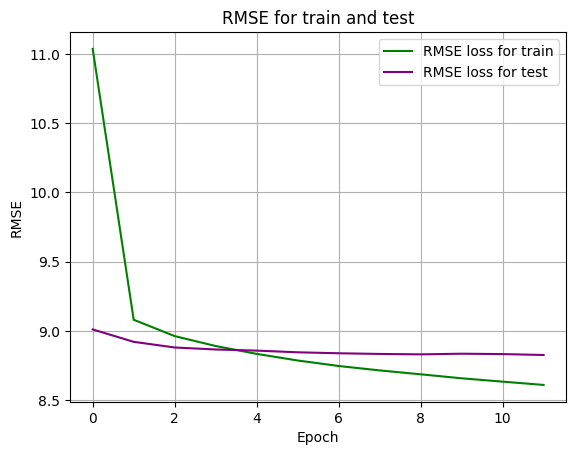

In [58]:
plt.plot(epochs, all_train_losses, 'g')
plt.plot(epochs, all_test_losses, 'purple')
plt.grid(True)
plt.legend(['RMSE loss for train', 'RMSE loss for test'])
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE for train and test')
plt.show()

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Подробнее опишу ход своих мыслей, а также все действия из второго задания.

1.   Сначала я использовал 1 полносвязный слой, как в предыдущем номере. RMSE было около 2000. На лекции часто говорилось о двуйслойных нейронных сетях, и я решил попробовать добавить 2-й полносвязный слой и функцию активации ReLU. Удалось добиться значительного уменьшения ошибки: лучшее ее значение стало около 160. Значения гиперпараметров в этом эксперименте, пока не подбирал, так что использовались просто "адекватные" для человеческого сознания значения.

2.   Далее я решил попробовать использовать предложенную в задании нормировку таргета. Действительно, предложение оказалось дельным: качество гораздо улучшилось, мы пробили значение лосса в 9.5

3.   Теперь я решил попробовать разные оптимизаторы. Сначала при использовнии Adam, SGD с momenum'ом и RMSprop и прошлых значениях гиперпараметров (которые мы пока не настраивали), ошибка пробила дно (на некоторых эпохах был аж 40). Но я подумал, что это очень странно и решил поизменять гиперпараметры. Зная что для Adam и RMSprop значение длины шага по умолчанию 0.001, я решил последовательно уменьшать lr с моего изначального 0.05 до 0.001, и вот... лосс стал уменьшаться. Пока остановимся на длине шага 0.001.

  Сравнивая Adam, RMSprop между собой я выбрал Adam, т.к. хотя и лоссы были похожи, но Adam достигал таких же значений на более ранних эпохах.

 Далее я вспомнил о том, что на четвертом семинаре мы применили Adam в связке с шедулером. Добавив его, удалось добиться незначительного улучшения. Итоговое качество для этого эксперимента стало 9.15 (на пятой эпохе).

4.   Работая со вторым заданиям, я понял, что изменение архитектуры влечет за собой аккуратный подбор гиперпараметров под конкретную архитектуру. Тогда логично сначала попробовать поработать именно с ней. Я пытался заменить функцию активации ReLU на какую-либо другую, но нет... ничего не уменьшило ошибку. Далее я решил пробовать менять количество выходов в первом слое, да иногда ошибка уменьшалась, но незначительно, хотелось бы более радикальных мер.

  Тогда я решил, добавить ещё один линейный слой. Логично посмотреть на ошибку при разном числе выходов в слоях. Сначала я пытался при каждом новом слое уменьшать число выходов в два раза и в целом было уже лучше. Но постепенно увеличивая число выходов после первого полносвязного слоя до 80, качество модели стало получше. Аналогичным образом мною были подобраны значения выходов для второго слоя - 50 и третьего - 20.

  Обрадовавшись, полученному лоссу (на пятой эпохе он был 8.95) я решил попробовать подобавлять еще слои и поизменять выходы каждого, но все эти попытки никак мне не помогли уменьшить ошибку на тесте.

5.   В данном эксперименте настало время изменять значения гиперпараметров.

  Начнём с изменения размера батча. Хоть я и достаточно подробно об этом рассказал ранее, но повторюсь ... в лекциях говорилось о том, что нужно аккуратно работать с большими батчами, и о том, что размер батча обычно порядка десятка или сотни. В связи с особенностями архитектуры берут степень двойки. Пробуя разные размеры батча  ∈[16,32,64,128,256,512,1024,2048] периодически меня пугало значительное увеличение ошибки, однако лучшее качество было при батче 128.


6.   Теперь, хоть ранее мы и меняли длину шага, но может можно улучшить полученные результаты. Опять же увеличение lr только в разы увеличивало ошибку, а уменьшение шага давало свои плоды: пробуя разные длины шага с 0.1 до 0.001, ошибка уменьшалась. Остановившись на lr = 0.001 я попробовал его ещё уменьшить. Радикальных перемен в лоссе уже не было, но при уменьшении прошлого шага в 0.75 раз (lr = 0.75 * 0.001 = 0.00075)  ошибка немного уменьшилась. Итоговая ошибка на тесте после экспериментов 5 и 6: 8.8256




***Итоговая ошибка на тесте: 8.8256***

Естественно я хотел ещё её уменьшить, но увы... ничего уже не помогало, ни какое-то другое масштабирование данных (отличное от StandardScaler'а), ни droput, печаль...

Источниками вдохновления для меня были: семинары 1-4, а также при написании RMSE [эти рассуждения](https://discuss.pytorch.org/t/rmse-loss-function/16540/2) направили меня в правильную сторону.